In [1]:
import gymnasium as gym
from gymnasium import spaces
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm

from IPython import display

In [2]:
device = torch.device('cuda')

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [4]:
class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [5]:
class MDP():
    
    def __init__(self, n_states, render_mode=None):
        self.start = 2
        self.n = n_states
        self.state = self.start
        
    def step(self, action):
        state_delta = action if action else - 1
        s_n = min(self.n, max(1, self.state + state_delta))
        r = 1 if (self.state == self.n and s_n == self.n) else 1/1000 if (self.state == 1 and s_n == 1) else 0
        self.state = s_n
        return torch.tensor([r], dtype=torch.float32, device=device), torch.tensor([self.state], dtype=torch.float32, device=device).unsqueeze(0)

    def reset(self):
        self.state = self.start
        return self.state

In [6]:
class DQN(nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_observations, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
        
    def forward(self, x):
        return self.model(x)

In [7]:
lr = 0.005
gamma = 0.99
batch_size = 300
e_strt = 1.0
e_fin = 0.0
e_decay = 0.0005

In [8]:
n_states = 10
steps = n_states + 9
env = MDP(n_states)

In [9]:
n_actions = 2
n_observations = 1

In [10]:
def select_action(state, t):
    epsilon = e_fin + (e_strt - e_fin) * math.exp(-t * e_decay)
    sample = random.random()
    if sample > epsilon:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1,1).to(device)
    else:
        return torch.tensor([[random.choice([0,1])]], device=device, dtype=torch.long)

In [42]:
def optimize_model():
    if len(memory) < batch_size:
        print('pog')
        return
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    # print(non_final_next_states.size(), non_final_next_states)
    
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    
    expected_state_action_values = reward_batch + gamma * next_state_values
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [45]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
memory = ReplayMemory(10000)

n_episodes = 1000

In [46]:
%%time
count = 1
rewards = []
for episode in tqdm.tqdm(range(n_episodes)):
    # print(f'episode {episode}')
    s = env.reset()
    s = torch.tensor([s], dtype=torch.float32, device=device).unsqueeze(0)
    reward = 0
    for t in range(steps):
        a = select_action(s, episode * steps + t)
        # print('s:', s)
        # print('a:', a)
        r, s_n = env.step(a)
        
        if t+1 == steps:
            print(s_n)
            s_n += 10
        else:
            reward += r.cpu().item()
        # print('r:', r)
        # print('s_n:', s_n)
        memory.push(s, a, s_n, r)
        s = s_n
        # print('s again:', s)
        
        optimize_model()
        
        if not (count % 50):
            # print('update')
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]
            target_net.load_state_dict(target_net_state_dict)
        
        count += 1
    rewards.append(reward)

  0%|▌                                                                                                                                                                                              | 3/1000 [00:00<00:39, 25.32it/s]

pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
tensor([[1.]], device='cuda:0')
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
tensor([[8.]], device='cuda:0')
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
tensor([[1.]], device='cuda:0')
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
tensor([[9.]], device='cuda:0')
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
tensor([[2.]], device='cuda:0')
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog


  1%|██                                                                                                                                                                                            | 11/1000 [00:00<00:29, 33.63it/s]

pog
pog
tensor([[1.]], device='cuda:0')
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
tensor([[5.]], device='cuda:0')
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
tensor([[8.]], device='cuda:0')
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
tensor([[6.]], device='cuda:0')
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
tensor([[1.]], device='cuda:0')
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
tensor([[3.]], device='cuda:0')
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
tensor([[6.]], device='cuda:0')
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
tensor([[1.]], device='cuda:0')
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
tensor([[10.]], device='cuda:0')
pog
pog


  2%|███                                                                                                                                                                                           | 16/1000 [00:00<00:28, 34.68it/s]

pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
tensor([[6.]], device='cuda:0')
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
pog
tensor([[2.]], device='cuda:0')
tensor([[1.]], device='cuda:0')


  2%|███▊                                                                                                                                                                                          | 20/1000 [00:00<00:52, 18.79it/s]

tensor([[10.]], device='cuda:0')
tensor([[2.]], device='cuda:0')
tensor([[8.]], device='cuda:0')


  2%|████▎                                                                                                                                                                                         | 23/1000 [00:01<01:02, 15.56it/s]

tensor([[9.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')


  3%|████▉                                                                                                                                                                                         | 26/1000 [00:01<01:12, 13.50it/s]

tensor([[10.]], device='cuda:0')
tensor([[9.]], device='cuda:0')
tensor([[7.]], device='cuda:0')


  3%|█████▎                                                                                                                                                                                        | 28/1000 [00:01<01:16, 12.74it/s]

tensor([[6.]], device='cuda:0')
tensor([[5.]], device='cuda:0')


  3%|█████▋                                                                                                                                                                                        | 30/1000 [00:01<01:23, 11.59it/s]

tensor([[9.]], device='cuda:0')
tensor([[10.]], device='cuda:0')


  3%|██████                                                                                                                                                                                        | 32/1000 [00:02<01:27, 11.06it/s]

tensor([[7.]], device='cuda:0')
tensor([[9.]], device='cuda:0')
tensor([[9.]], device='cuda:0')


  3%|██████▍                                                                                                                                                                                       | 34/1000 [00:02<01:29, 10.81it/s]

tensor([[6.]], device='cuda:0')
tensor([[3.]], device='cuda:0')


  4%|██████▊                                                                                                                                                                                       | 36/1000 [00:02<01:33, 10.34it/s]

tensor([[7.]], device='cuda:0')
tensor([[8.]], device='cuda:0')


  4%|███████▏                                                                                                                                                                                      | 38/1000 [00:02<01:34, 10.17it/s]

tensor([[10.]], device='cuda:0')
tensor([[8.]], device='cuda:0')


  4%|███████▌                                                                                                                                                                                      | 40/1000 [00:02<01:09, 13.72it/s]

tensor([[6.]], device='cuda:0')


KeyboardInterrupt: 

In [144]:
# rewards

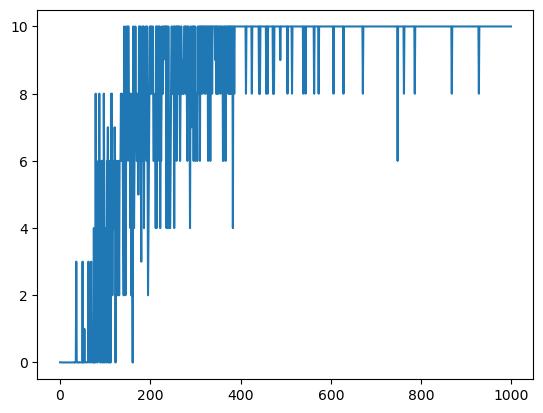

In [ ]:
plt.plot(range(n_episodes), rewards)

In [255]:
for t in range(1000):
    
    eps = e_fin + (e_strt - e_fin) * math.exp(-t * e_decay)
    # print(eps, math.exp(-1 * t / 2000))
    # print(eps, math.exp(-t * e_decay))